<a href="https://colab.research.google.com/github/vsathyap/PyTorch_Fundamentals/blob/main/IntroCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial 14: Import MNIST Images**



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
# MNIST Images to 4D Tensors Number of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [4]:
# Training Data
train_data = datasets.MNIST(root = '/cnn_data',train=True,download = True, transform=transform)
train_data

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
# Test data
test_data = datasets.MNIST(root = '/cnn_data',train=False,download = True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

# **Tutorial 15: Convolutional and Pooling Layers**

In [6]:
# Create a small batch size of images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
# Define the CNN Model (2 layers)
conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=3,stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=3,stride=1)

In [8]:
# Let's grab 1 MNIST image
for i, (X_train,y_train) in enumerate(train_data):
  break

print(X_train.shape)

torch.Size([1, 28, 28])


In [9]:
X = X_train.view(1,1,28,28)

In [10]:
# Perform our first coonvolution
x = F.relu(conv1(X)) # ReLu activation function
print(x.shape)

torch.Size([1, 6, 26, 26])


In [11]:
# Pass through the pooling layer
x = F.max_pool2d(x,2,2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [12]:
# Pass though the 2nd Conv layer
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [13]:
# Pooling layer
x = F.max_pool2d(x,2,2)
print(x.shape)

torch.Size([1, 16, 5, 5])


# **Tutorial 16: CNN Neural Network**

In [14]:
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=3, stride=1)
    #fully connected layers
    self.fc1 = nn.Linear(in_features=5*5*16,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=84)
    self.fc3 = nn.Linear(in_features=84,out_features=10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,kernel_size=2,stride=2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,kernel_size=2,stride=2)

    # Flatten our data
    X = X.view(-1,16*5*5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X,dim=1)




In [15]:
# Create an instance
torch.manual_seed(41)
model = CNNModel()
model

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# **Tutorial 17 : Train and Test the CNN**

In [25]:
import time
start_time = time.time()

# Variables to track
epoch = 5
train_losses = []
trn_correct = []
test_losses = []
tst_correct = []

# For loop for epochs
for e in range(epoch):
  train_correct = 0
  test_correct = 0

  for b, (X_train,y_train) in enumerate(train_loader):
    y_out = model(X_train)
    loss = criterion(y_out,y_train)

    y_pred = torch.max(y_out.data,1)[1]
    batch_correct = (y_pred==y_train).sum()
    train_correct +=batch_correct

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b%600==0):
      print(f"Epoch: {e}, Batch: {b}, Training Loss: {loss.item()}")

  train_losses.append(loss)
  trn_correct.append(train_correct)

  for b, (X_test,y_test) in enumerate(test_loader):
    with torch.no_grad():
      y_out = model(X_test)
      loss = criterion(y_out,y_test)

      y_val = torch.max(y_out.data,1)[1]
      batch_correct = (y_val==y_test).sum()
      test_correct +=batch_correct

  test_losses.append(loss)
  tst_correct.append(test_correct)


current_time = time.time()
total_time = current_time-start_time
print(f"Training took {total_time/60} minutes")

Epoch: 0, Batch: 0, Training Loss: 0.00045666570076718926
Epoch: 0, Batch: 600, Training Loss: 0.13590142130851746
Epoch: 0, Batch: 1200, Training Loss: 8.368237104150467e-06
Epoch: 0, Batch: 1800, Training Loss: 3.0465784220723435e-05
Epoch: 0, Batch: 2400, Training Loss: 0.02668384090065956
Epoch: 0, Batch: 3000, Training Loss: 0.0037678673397749662
Epoch: 0, Batch: 3600, Training Loss: 0.001439423649571836
Epoch: 0, Batch: 4200, Training Loss: 0.00043795336387120187
Epoch: 0, Batch: 4800, Training Loss: 0.0026849419809877872
Epoch: 0, Batch: 5400, Training Loss: 0.0019812057726085186
Epoch: 1, Batch: 0, Training Loss: 0.00015881330182310194
Epoch: 1, Batch: 600, Training Loss: 5.707907257601619e-05
Epoch: 1, Batch: 1200, Training Loss: 4.4464622988016345e-06
Epoch: 1, Batch: 1800, Training Loss: 8.06492316769436e-05
Epoch: 1, Batch: 2400, Training Loss: 6.31801731287851e-06
Epoch: 1, Batch: 3000, Training Loss: 0.00038931131712161005
Epoch: 1, Batch: 3600, Training Loss: 0.068159915

# **Tutorial 18: Plotting the CNN results**

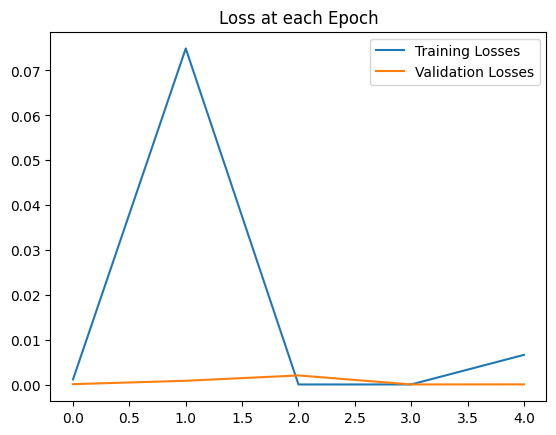

In [26]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses,label = 'Training Losses')
plt.plot(test_losses,label = 'Validation Losses')
plt.title('Loss at each Epoch')
plt.legend()

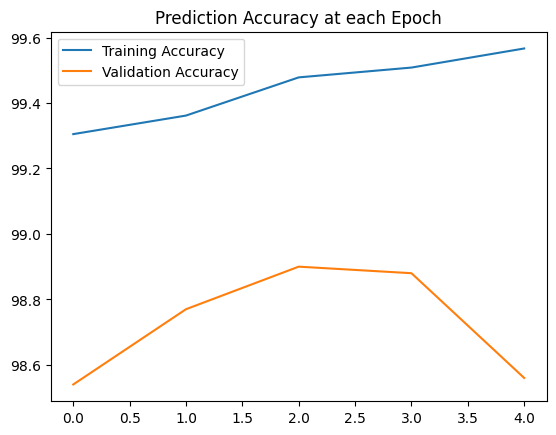

In [47]:
#train_accuracy = []
plt.plot([t/60000*100 for t in trn_correct],label = 'Training Accuracy')
plt.plot([t/10000*100 for t in tst_correct],label = 'Validation Accuracy')
plt.title('Prediction Accuracy at each Epoch')
plt.legend()


In [48]:
test_data[3143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [52]:
check_data = test_data[3143][0].reshape(28,28)
check_data.shape

torch.Size([28, 28])

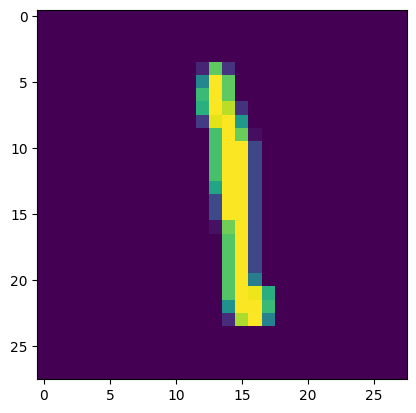

In [53]:
plt.imshow(check_data)

In [59]:
model.eval()
with torch.no_grad():
  y_out = model(test_data[3143][0].view(1,1,28,28))
  y_pred = torch.max(y_out,1)[1]
  print(f"The Image is : {y_pred.item()}")

The Image is : 1
